# Import libraries

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import config
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from tqdm import tqdm
from GMHI import GMHI

# Load data

In [5]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [0]]
GMHI2_scores_ISV = pd.read_csv(os.path.join(config.LOG_DIR, "GMHI2_scores_ISV.csv"), index_col=[0, 1])
full_meta = pd.read_csv(os.path.join(config.RAW_DIR, "raw_training.csv"), index_col=[0, 3])
display(X.head())
display(y.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283245        0.106067                     0.106067   
         SAMN03283294        0.000000                     0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283245                                            0.106067   
         SAMN03283294                                            0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283245                                               0.106067                      
         SAMN03283294                                               0.000000                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283245                                               0.106067                                             
         SAMN03283294                                               0.000000                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283245                                               0.072453                                                                   
         SAMN03283294                                               0.000000                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283245                              True
         SAMN03283294                              True

In [10]:
GMHI2_scores_ISV["UNKNOWN"] = full_meta.loc[GMHI2_scores_ISV.index][["UNKNOWN"]]
GMHI2_scores_ISV["num_taxa"] = (X > config.PRESENCE_CUTOFF).sum(axis=1)
GMHI2_scores_ISV

GMHI2_ISV   UNKNOWN  num_taxa
Study_ID Sample Accession                               
GMHI-10  SAMN03283239       1.876379  61.18781       126
         SAMN03283266       0.273884  60.56958       173
         SAMN03283281       0.942891  79.32643       185
         SAMN03283245       1.152237  91.08095       139
         SAMN03283294       2.140906  72.63747       201
...                              ...       ...       ...
P98      SAMEA6104852       0.581640  54.57744       270
         SAMEA6104851      -0.988054  32.17805       238
         SAMEA6104850       0.817093  51.15968       240
         SAMEA6104885      -0.135115  46.54158       174
         SAMEA6104858       0.887893  40.38684       212

[8869 rows x 3 columns]

Text(0.5, 0, 'Number of identified taxa')

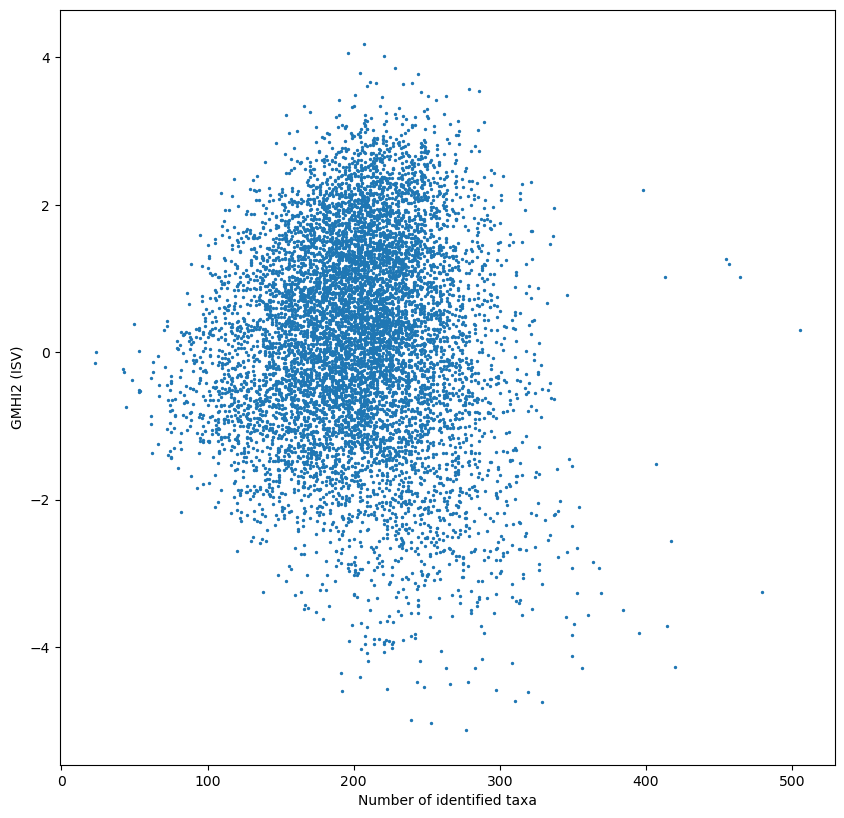

In [31]:
plt.figure(figsize=(10, 10), dpi=100)

plt.scatter(GMHI2_scores_ISV["num_taxa"], GMHI2_scores_ISV["GMHI2_ISV"], s=2)

plt.ylabel("GMHI2 (ISV)")
plt.xlabel("Number of identified taxa")


Text(0.5, 0, '% UNKNOWN')

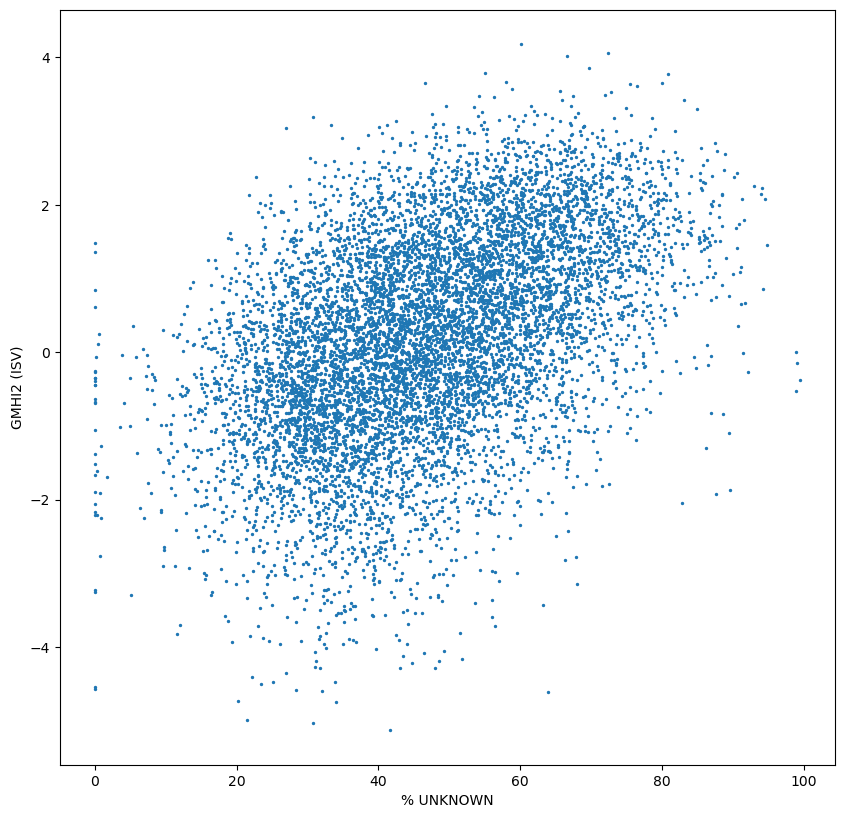

In [32]:
plt.figure(figsize=(10, 10), dpi=100)

plt.scatter(GMHI2_scores_ISV["UNKNOWN"], GMHI2_scores_ISV["GMHI2_ISV"], s=2)

plt.ylabel("GMHI2 (ISV)")
plt.xlabel("% UNKNOWN")

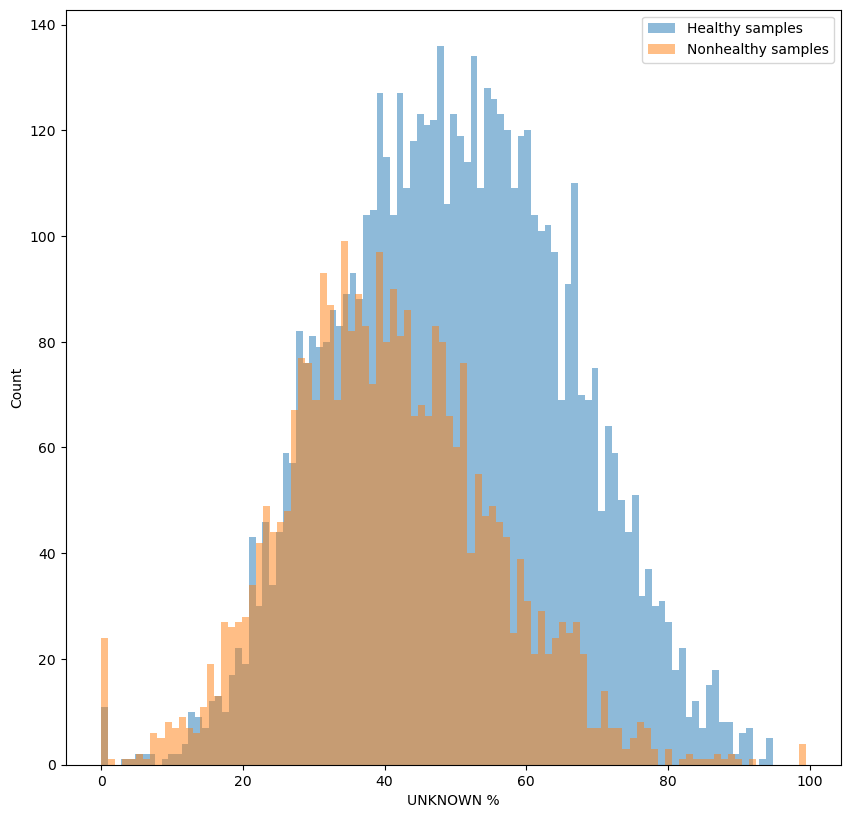

In [81]:
plt.figure(figsize=(10, 10), dpi=100)

plt.hist(GMHI2_scores_ISV.iloc[y.values.flatten()]["UNKNOWN"], bins=100, label="Healthy samples", alpha=0.5)
plt.hist(GMHI2_scores_ISV.iloc[~y.values.flatten()]["UNKNOWN"], bins=100, label="Nonhealthy samples", alpha=0.5)
plt.legend()
plt.xlabel("UNKNOWN %")
plt.ylabel("Count")
plt.show()

In [40]:
GMHI2_scores_ISV["correct"] = (GMHI2_scores_ISV["GMHI2_ISV"] > 0).values.flatten() == y.values.flatten()
GMHI2_scores_ISV

GMHI2_ISV   UNKNOWN  num_taxa  correct
Study_ID Sample Accession                                        
GMHI-10  SAMN03283239       1.876379  61.18781       126     True
         SAMN03283266       0.273884  60.56958       173     True
         SAMN03283281       0.942891  79.32643       185     True
         SAMN03283245       1.152237  91.08095       139     True
         SAMN03283294       2.140906  72.63747       201     True
...                              ...       ...       ...      ...
P98      SAMEA6104852       0.581640  54.57744       270     True
         SAMEA6104851      -0.988054  32.17805       238    False
         SAMEA6104850       0.817093  51.15968       240     True
         SAMEA6104885      -0.135115  46.54158       174    False
         SAMEA6104858       0.887893  40.38684       212     True

[8869 rows x 4 columns]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

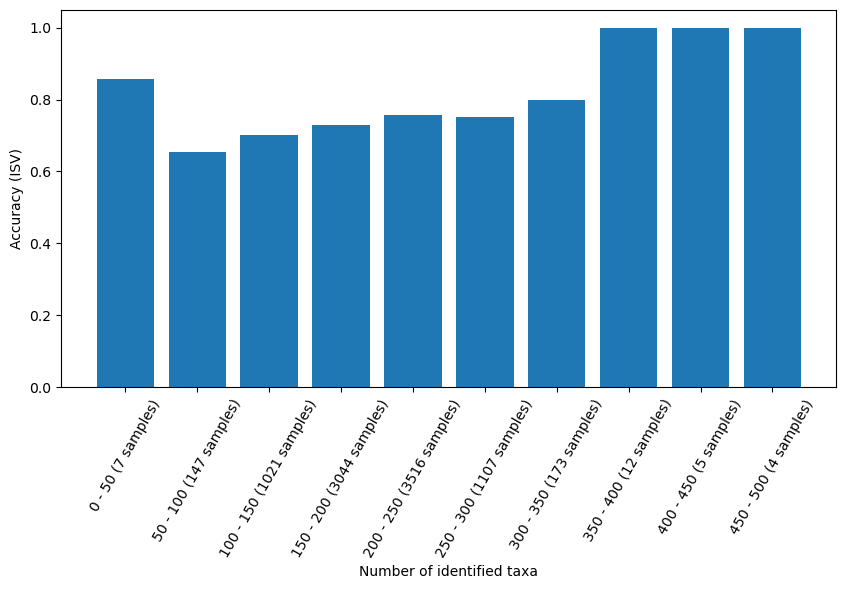

In [73]:
ranges = [(i, i + 50) for i in range(0, 451, 50)]
accuracies = [GMHI2_scores_ISV[(r[0] <= GMHI2_scores_ISV["num_taxa"]) & (GMHI2_scores_ISV["num_taxa"] <= r[1])]["correct"].mean() for r in ranges]
counts = [GMHI2_scores_ISV[(r[0] <= GMHI2_scores_ISV["num_taxa"]) & (GMHI2_scores_ISV["num_taxa"] <= r[1])].shape[0] for r in ranges]

labels = [f"{r[0]} - {r[1]} ({c} samples)" for r, c in zip(ranges, counts)]


plt.figure(figsize=(10, 5), dpi=100)

plt.bar(labels, accuracies)
plt.ylabel("Accuracy (ISV)")
plt.xlabel("Number of identified taxa")

plt.xticks(rotation = 60)

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

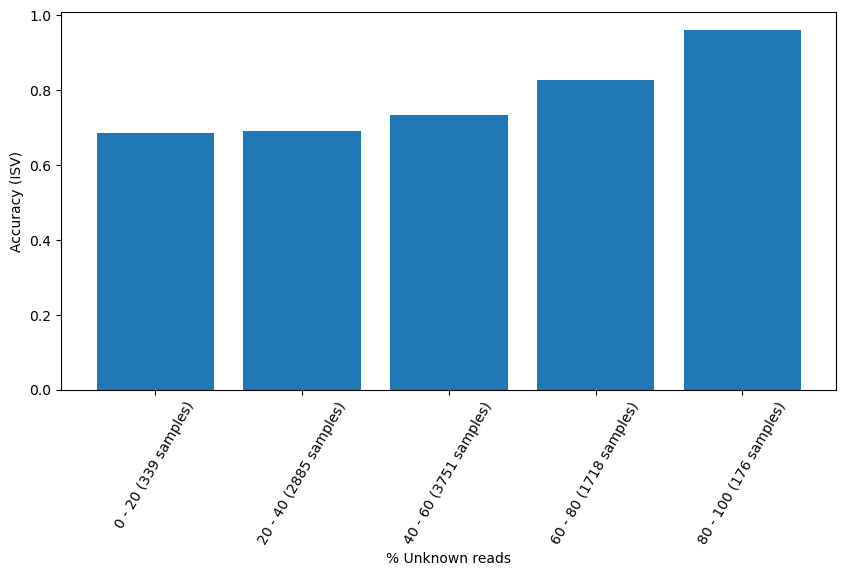

In [74]:
ranges = [(i, i + 20) for i in range(0, 81, 20)]
accuracies = [GMHI2_scores_ISV[(r[0] <= GMHI2_scores_ISV["UNKNOWN"]) & (GMHI2_scores_ISV["UNKNOWN"] <= r[1])]["correct"].mean() for r in ranges]
counts = [GMHI2_scores_ISV[(r[0] <= GMHI2_scores_ISV["UNKNOWN"]) & (GMHI2_scores_ISV["UNKNOWN"] <= r[1])].shape[0] for r in ranges]
labels = [f"{r[0]} - {r[1]} ({c} samples)" for r, c in zip(ranges, counts)]

plt.figure(figsize=(10, 5), dpi=100)

plt.bar(labels, accuracies)
plt.ylabel("Accuracy (ISV)")
plt.xlabel("% Unknown reads")

plt.xticks(rotation = 60)